In [65]:
import time

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing.text import Tokenizer

#potrzebne do załadowania danych testowych 
import numpy as np 

#potrzebne do wykresu "confusion matrix"
import matplotlib.pyplot as plt 
import itertools

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score #potrzebne do wykresu "confusion matrix" oraz raportów

In [20]:
# SENTIMENT
#Przypisanie rezultatów do skali liczbowej, przypisanie nazw do rezultatów 
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

tokenizer = Tokenizer()

# wprowadzenie parametrów uczenia maszynowego
SEQUENCE_LENGTH = 300 #maksymalna długość tekstu wprowadzone 
W2V_SIZE = 300
BATCH_SIZE = 1024

In [9]:
#---------------------------------------------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

dataset_path = r"C:\Users\aleks\Downloads\training.1600000.processed.noemoticon.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

#---------------------------------------------------------------------------------

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
#random state ułatwia analizę kodu przez eliminację losowości, jednocześnie umożliwiając jej póżniejsze dodanie i eksperymenty przez zmienianie random state
print("TRAIN size:", len(df_train)) #wyświetlanie wielkości zbioru uczącego
print("TEST size:", len(df_test)) #wyświetlanie wielkości zbioru testowego

#---------------------------------------------------------------------------------

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Open file: C:\Users\aleks\Downloads\training.1600000.processed.noemoticon.csv
TRAIN size: 1280000
TEST size: 320000


**ŁADOWANIE MODELI**
Do sprawnego działania potrzebne są oba modele (wektorowy oraz klasyfikacyjny) oraz enkoder i tokenizer 

In [11]:
from tensorflow.keras.models import load_model

model = load_model("Modele/model.h5") #Ładowanie modelu

import gensim
from gensim.models import KeyedVectors

w2v_model = gensim.models.Word2Vec.load('Modele/model.w2v') #Ładowanie modelu wektorowego

import pickle
#potrzebne do załadowania 2 ostatnich modeli

tokenizer = pickle.load(open("Modele/tokenizer.pkl", "rb")) #ładowanie tokenizera
encoder = pickle.load(open("Modele/encoder.pkl", "rb")) #ładowanie enkodera

**Ładowanie kodu**

In [5]:
x_test = np.loadtxt('Dane/x_test.txt')
y_test = np.loadtxt('Dane/y_test.txt')

In [12]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [13]:
def predict(text, include_neutral=True):
    start_at = time.time()

    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)

    # Predict
    score_array = model.predict([x_test])[0]
    score = score_array.item()  # Extract scalar value

    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {
        "label": label,
        "score": score,
        "elapsed_time": time.time() - start_at
    }

**TESTY NA POJEDYŃCZYCH ZDANIACH**

Sprawdzamy działanie modelu dzięki funkcji "predict"

In [17]:
predict("I love women, they are so nice and cudly")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


{'label': 'POSITIVE',
 'score': 0.9521762728691101,
 'elapsed_time': 0.08209443092346191}

In [15]:
predict("I live in Birmingham")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


{'label': 'NEUTRAL',
 'score': 0.6578546762466431,
 'elapsed_time': 0.11648082733154297}

In [16]:
predict("Eisenhower was a terrible president, but people still glaze him")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


{'label': 'NEGATIVE',
 'score': 0.13022296130657196,
 'elapsed_time': 0.05822396278381348}



**EVALUACJA MODELU NA DANYCH TESTOWYCH**

Sprawdzamy, czy model wytrenowany na danych uczących skutecznie sklasyfikuje dane testowe

In [22]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 237s 758ms/step - accuracy: 0.7902 - loss: 0.4441

ACCURACY: 0.789968729019165
LOSS: 0.4449510872364044
CPU times: total: 15min 6s
Wall time: 4min 22s


In [44]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step
CPU times: total: 15min 26s
Wall time: 1min 42s


In [53]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [70]:
y_test_1d = y_test_1d.astype(int)
#y_test_1d = y_test_1d.astype(str)
print(y_test_1d[:100])

y_pred_1d = pd.Series(y_pred_1d)
y_pred_1d = y_pred_1d.replace({"POSITIVE": 0, "NEGATIVE": 4})
print(y_pred_1d[:100])

[0 0 0 0 0 0 4 0 0 4 4 4 4 0 4 4 4 0 0 0 0 4 4 4 0 0 4 0 0 4 4 0 0 0 0 0 0
 4 0 4 4 4 4 4 4 0 4 0 4 0 4 4 0 4 4 0 4 4 0 4 0 4 4 4 4 4 0 0 4 0 0 0 4 4
 4 0 4 4 4 0 4 0 4 4 0 0 0 4 0 4 4 4 4 4 4 4 4 0 0 0]
0     4
1     0
2     0
3     4
4     4
     ..
95    0
96    4
97    4
98    4
99    0
Length: 100, dtype: int64


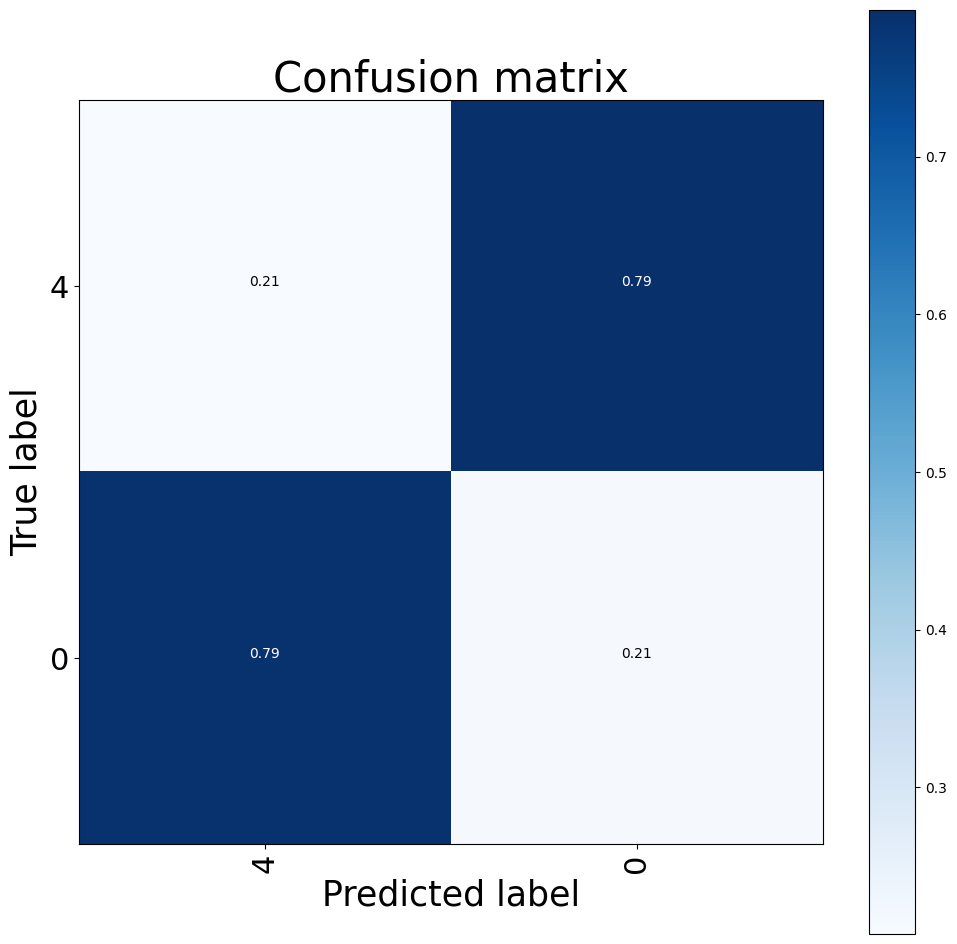

CPU times: total: 203 ms
Wall time: 206 ms


In [71]:
%%time

#Confusion martix - dane testowe vs predykcje 
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [80]:
print(classification_report(y_test_1d, y_pred_1d))

#TP - True Positive, FP - False Positive, TF - True Nagative, FN - False Nagative 

#Prezycja (presition) - TP / TP + FP
#Czułość (sensitivity/recall) - TP / TP + FN
#Support - ilość przykładów w kategorii

              precision    recall  f1-score   support

           0       0.21      0.21      0.21    159494
           4       0.21      0.21      0.21    160506

    accuracy                           0.21    320000
   macro avg       0.21      0.21      0.21    320000
weighted avg       0.21      0.21      0.21    320000



In [79]:
#Końcowy wynik efektywności

1 - accuracy_score(y_test_1d, y_pred_1d)

0.78996875